In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from model_module import model_preparation, best_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [47]:
df = pd.read_csv("./data/angelone_eq_15min_2018_2025.csv").set_index("datetime").drop(columns=["timestamp"])
df.head()

,open,high,low,close,volume
datetime,,,,,
2020-10-05 09:45:00+05:30,275.0,275.00,275.00,275.0,306762
2020-10-05 10:00:00+05:30,275.0,275.00,275.00,275.0,0
2020-10-05 10:15:00+05:30,272.6,292.35,257.00,278.6,2886820
2020-10-05 10:30:00+05:30,278.6,292.40,275.00,286.7,949825
2020-10-05 10:45:00+05:30,286.7,294.80,285.55,294.0,831097


#### Creating Features

    momentum Features

In [48]:
df['return_4'] = np.log(df['close'] / df['close'].shift(4))   # 1 hour
df['return_13'] = np.log(df['close'] / df['close'].shift(13)) # ~3 hours
df['return_26'] = np.log(df['close'] / df['close'].shift(26)) # 1 day

    Volume

In [49]:
df = df.copy()
lookback = 20  # 20 bars = 5 hours of 15min data

df["volume_ma"] = df["volume"].rolling(window=lookback).mean()
df["volume_ratio"] = df["volume"] / df["volume_ma"]

# Clean up
df = df.dropna(how="any")

    RSI

In [50]:
# RSI calculation
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI with standard 14-period
df["rsi_14"] = calculate_rsi(df["close"], period=14)

# Clean up
df = df.dropna(how="any")

# Check the feature
print("RSI Statistics:")
print(df["rsi_14"].describe())
print(f"\nOverbought (>70): {(df['rsi_14'] > 70).sum()} bars")
print(f"Oversold (<30): {(df['rsi_14'] < 30).sum()} bars")


RSI Statistics:
count    32008.000000
mean        49.333163
std         19.061507
min          0.000000
25%         35.177163
50%         49.368087
75%         63.157895
max        100.000000
Name: rsi_14, dtype: float64

Overbought (>70): 4874 bars
Oversold (<30): 5469 bars


    MACD

In [51]:
# MACD calculation
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

df["macd"], df["macd_signal"], df["macd_hist"] = calculate_macd(df["close"])

# Normalize MACD features by price (make them relative)
df["macd_norm"] = df["macd"] / df["close"]
df["macd_hist_norm"] = df["macd_hist"] / df["close"]

# Clean up
df = df.dropna(how="any")

print("MACD Statistics:")
print(df[["macd_norm", "macd_hist_norm"]].describe())

MACD Statistics:
          macd_norm  macd_hist_norm
count  32008.000000    32008.000000
mean       0.000345        0.000005
std        0.007443        0.002041
min       -0.049496       -0.016980
25%       -0.003475       -0.000954
50%        0.000006       -0.000060
75%        0.003886        0.000902
max        0.045701        0.016795


    Moving Averages

In [52]:
# Moving averages (just for calculation, not direct features)
df["5ma"] = df["close"].rolling(5).mean()
df["10ma"] = df["close"].rolling(10).mean()
df["50ma"] = df["close"].rolling(50).mean()
df["200ma"] = df["close"].rolling(200).mean()  # Fixed: was 100

# RELATIVE features (normalized by price)
df["5_10_ma_diff_pct"] = (df["5ma"] - df["10ma"]) / df["close"]
df["close_5ma_diff_pct"] = (df["close"] - df["5ma"]) / df["close"]
df["close_10ma_diff_pct"] = (df["close"] - df["10ma"]) / df["close"]
df["golden_cross_pct"] = (df["50ma"] - df["200ma"]) / df["close"]

# Additional useful MA features
df["close_50ma_diff_pct"] = (df["close"] - df["50ma"]) / df["close"]
df["close_200ma_diff_pct"] = (df["close"] - df["200ma"]) / df["close"]

# Slope/momentum of MAs (rate of change)
df["5ma_roc"] = df["5ma"].pct_change(periods=5)
df["50ma_roc"] = df["50ma"].pct_change(periods=10)


In [53]:
# High-Low range features
df["hl_range"] = (df["high"] - df["low"]) / df["close"]  # Normalized
df["hl_range_ma"] = df["hl_range"].rolling(20).mean()
df["hl_range_ratio"] = df["hl_range"] / df["hl_range_ma"]  # Current vs average

# Close position within bar
df["close_position"] = (df["close"] - df["low"]) / (df["high"] - df["low"])  # 0 to 1

df = df.dropna()

    Candlestick/Microstructure Features

In [54]:
# === CANDLESTICK BODY & WICKS ===
df["body_size"] = abs(df["close"] - df["open"]) / df["close"]
df["upper_wick"] = (df["high"] - df[["open", "close"]].max(axis=1)) / df["close"]
df["lower_wick"] = (df[["open", "close"]].min(axis=1) - df["low"]) / df["close"]

# Body direction
df["body_direction"] = np.sign(df["close"] - df["open"])

# === OPEN-CLOSE RELATIONSHIPS ===
df["open_close_diff"] = (df["close"] - df["open"]) / df["close"]
df["high_close_diff"] = (df["high"] - df["close"]) / df["close"]
df["low_close_diff"] = (df["close"] - df["low"]) / df["close"]

# === VOLUME-WEIGHTED PRICE (VWAP) ===
df["vwap_5"] = (df["close"] * df["volume"]).rolling(5).sum() / df["volume"].rolling(5).sum()
df["vwap_10"] = (df["close"] * df["volume"]).rolling(10).sum() / df["volume"].rolling(10).sum()
df["vwap_5_diff"] = (df["close"] - df["vwap_5"]) / df["close"]
df["vwap_10_diff"] = (df["close"] - df["vwap_10"]) / df["close"]

# === MOMENTUM OF MICROSTRUCTURE ===
df["close_position_change"] = df["close_position"].diff()
df["body_size_ratio"] = df["body_size"] / df["body_size"].rolling(10).mean()

# === BUYING/SELLING PRESSURE PROXIES ===
# Approximation: If close near high = buying pressure
df["buying_pressure"] = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
df["selling_pressure"] = (df["high"] - df["close"]) / (df["high"] - df["low"] + 1e-10)

# Clean up
df = df.dropna()

print(f"Added microstructure features. New shape: {df.shape}")

Added microstructure features. New shape: (31661, 47)


#### Creating Target

In [55]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift(1))
df = df.dropna(how="any")

    Shift to avoid lookahead bias

In [56]:
df = df.copy()
df["shifted_log_return"] = df["close_log_return"].shift(-1)

In [57]:
df["close_log_return_lag1"] = df["shifted_log_return"].shift(1)
df["close_log_return_lag2"] = df["shifted_log_return"].shift(2)
df["close_log_return_lag3"] = df["shifted_log_return"].shift(3)
df = df.dropna(how="any")

#### Visualization discarded for later

In [58]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # Assuming your data is loaded
# # df has columns: ['open', 'high', 'low', 'close', 'volume']

# # Calculate log returns (1-bar forward)
# df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# # Remove NaN
# df = df.dropna()

# # ============================================
# # 1. BASIC STATISTICS
# # ============================================
# print("="*60)
# print("LOG RETURNS DISTRIBUTION ANALYSIS")
# print("="*60)
# print(f"Total samples: {len(df)}")
# print(f"Mean: {df['log_return'].mean():.6f}")
# print(f"Std Dev: {df['log_return'].std():.6f}")
# print(f"Skewness: {df['log_return'].skew():.4f}")
# print(f"Kurtosis: {df['log_return'].kurtosis():.4f}")
# print(f"Min: {df['log_return'].min():.4f}")
# print(f"Max: {df['log_return'].max():.4f}")
# print()

# # ============================================
# # 2. PERCENTILE ANALYSIS (CRITICAL)
# # ============================================
# percentiles = [1, 5, 10, 20, 25, 40, 50, 60, 75, 80, 90, 95, 99]
# print("PERCENTILE BREAKDOWN:")
# print("-" * 60)
# for p in percentiles:
#     val = np.percentile(df['log_return'], p)
#     print(f"{p:3d}th percentile: {val:8.4f} ({val*100:6.2f}%)")
# print()

# # ============================================
# # 3. PROPOSED CLASS BOUNDARIES
# # ============================================
# # Based on symmetric percentiles
# p10 = np.percentile(df['log_return'], 10)  # Class 4: Big Down
# p30 = np.percentile(df['log_return'], 30)  # Class 2: Small Down
# p70 = np.percentile(df['log_return'], 70)  # Class 1: Small Up
# p90 = np.percentile(df['log_return'], 90)  # Class 3: Big Up

# print("PROPOSED CLASS BOUNDARIES (Percentile-based):")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < {p10:.4f} ({p10*100:.2f}%)")
# print(f"Class 2 (Small Down):  {p10:.4f} to {p30:.4f}")
# print(f"Class 0 (Neutral):     {p30:.4f} to {p70:.4f}")
# print(f"Class 1 (Small Up):    {p70:.4f} to {p90:.4f}")
# print(f"Class 3 (Big Up):      return > {p90:.4f} ({p90*100:.2f}%)")
# print()

# # Alternative: Fixed percentage boundaries
# print("ALTERNATIVE: FIXED PERCENTAGE BOUNDARIES:")
# print("-" * 60)
# print(f"Class 4 (Big Down):    return < -0.50%")
# print(f"Class 2 (Small Down):  -0.50% to -0.15%")
# print(f"Class 0 (Neutral):     -0.15% to +0.15%")
# print(f"Class 1 (Small Up):    +0.15% to +0.50%")
# print(f"Class 3 (Big Up):      return > +0.50%")
# print()

# # Count samples in fixed boundaries
# class_4_count = len(df[df['log_return'] < -0.005])
# class_2_count = len(df[(df['log_return'] >= -0.005) & (df['log_return'] < -0.0015)])
# class_0_count = len(df[(df['log_return'] >= -0.0015) & (df['log_return'] < 0.0015)])
# class_1_count = len(df[(df['log_return'] >= 0.0015) & (df['log_return'] < 0.005)])
# class_3_count = len(df[df['log_return'] >= 0.005])

# print("Sample counts with fixed boundaries:")
# print(f"Class 0 (Neutral): {class_0_count} ({class_0_count/len(df)*100:.1f}%)")
# print(f"Class 1 (Small Up): {class_1_count} ({class_1_count/len(df)*100:.1f}%)")
# print(f"Class 2 (Small Down): {class_2_count} ({class_2_count/len(df)*100:.1f}%)")
# print(f"Class 3 (Big Up): {class_3_count} ({class_3_count/len(df)*100:.1f}%)")
# print(f"Class 4 (Big Down): {class_4_count} ({class_4_count/len(df)*100:.1f}%)")
# print()

# # ============================================
# # 4. VISUALIZATION
# # ============================================
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Histogram with KDE
# axes[0, 0].hist(df['log_return'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
# axes[0, 0].axvline(df['log_return'].mean(), color='red', linestyle='--', label=f'Mean: {df["log_return"].mean():.4f}')
# axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.3, label='Zero')
# axes[0, 0].set_xlabel('Log Return')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].set_title('Distribution of Log Returns')
# axes[0, 0].legend()
# axes[0, 0].grid(alpha=0.3)

# # Q-Q Plot (Test for normality)
# stats.probplot(df['log_return'], dist="norm", plot=axes[0, 1])
# axes[0, 1].set_title('Q-Q Plot (Normality Test)')
# axes[0, 1].grid(alpha=0.3)

# # Boxplot
# axes[1, 0].boxplot(df['log_return'], vert=True)
# axes[1, 0].set_ylabel('Log Return')
# axes[1, 0].set_title('Boxplot (Outlier Detection)')
# axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
# axes[1, 0].grid(alpha=0.3)

# # Class boundaries visualization
# axes[1, 1].hist(df['log_return'], bins=100, alpha=0.5, color='gray', edgecolor='black')
# axes[1, 1].axvline(p10, color='red', linestyle='--', linewidth=2, label=f'10th: {p10:.4f}')
# axes[1, 1].axvline(p30, color='orange', linestyle='--', linewidth=2, label=f'30th: {p30:.4f}')
# axes[1, 1].axvline(p70, color='green', linestyle='--', linewidth=2, label=f'70th: {p70:.4f}')
# axes[1, 1].axvline(p90, color='blue', linestyle='--', linewidth=2, label=f'90th: {p90:.4f}')
# axes[1, 1].set_xlabel('Log Return')
# axes[1, 1].set_ylabel('Frequency')
# axes[1, 1].set_title('Proposed Class Boundaries (Percentile-based)')
# axes[1, 1].legend()
# axes[1, 1].grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig('log_returns_distribution_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ============================================
# # 5. NORMALITY TEST
# # ============================================
# # Jarque-Bera test
# jb_stat, jb_pvalue = stats.jarque_bera(df['log_return'])
# print("NORMALITY TESTS:")
# print("-" * 60)
# print(f"Jarque-Bera statistic: {jb_stat:.2f}")
# print(f"Jarque-Bera p-value: {jb_pvalue:.6f}")
# if jb_pvalue < 0.05:
#     print("→ Returns are NOT normally distributed (reject null)")
# else:
#     print("→ Returns appear normally distributed")
# print()

# # ============================================
# # 6. AUTOCORRELATION CHECK
# # ============================================
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# plot_acf(df['log_return'].dropna(), lags=50, ax=axes[0])
# axes[0].set_title('Autocorrelation Function (ACF)')
# plot_pacf(df['log_return'].dropna(), lags=50, ax=axes[1])
# axes[1].set_title('Partial Autocorrelation Function (PACF)')
# plt.tight_layout()
# plt.savefig('autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("ACF/PACF analysis saved. Check for:")
# print("- Significant lags → momentum/mean reversion patterns")
# print("- All lags near zero → random walk (no predictability)")
# print()

# # ============================================
# # 7. TIME-BASED ANALYSIS
# # ============================================
# # Assuming you have datetime index
# if 'datetime' in df.columns or isinstance(df.index, pd.DatetimeIndex):
#     if 'datetime' not in df.columns:
#         df['datetime'] = df.index
    
#     df['hour'] = pd.to_datetime(df['datetime']).dt.hour
#     df['year'] = pd.to_datetime(df['datetime']).dt.year
    
#     print("VOLATILITY BY HOUR (Intraday Pattern):")
#     print("-" * 60)
#     hourly_stats = df.groupby('hour')['log_return'].agg(['mean', 'std', 'count'])
#     print(hourly_stats)
#     print()
    
#     print("ANNUAL STATISTICS (Regime Changes):")
#     print("-" * 60)
#     yearly_stats = df.groupby('year')['log_return'].agg(['mean', 'std', 'count'])
#     print(yearly_stats)
#     print()

# print("="*60)
# print("ANALYSIS COMPLETE")
# print("="*60)

#### Model Preparation

    Creating Target and Deciding Features

In [59]:
X = df[[
    "buying_pressure",
    "close_position",
    "close_5ma_diff_pct",
    "high_close_diff",
    "body_size",
    "close_log_return_lag1",
    "close_log_return_lag2",
    "return_4",
    "return_13",
    "return_26",
    "volume_ratio",
    "macd_norm",
    "rsi_14"
]]


# y = (df["shifted_log_return"] > 0).astype(int)


In [60]:
# Percentile-based classes
p10 = df['shifted_log_return'].quantile(0.10)  # -0.0041
p30 = df['shifted_log_return'].quantile(0.30)  # -0.0013
p70 = df['shifted_log_return'].quantile(0.70)  # 0.0010
p90 = df['shifted_log_return'].quantile(0.90)  # 0.0042

def label_class(ret):
    if ret < p10: return 4      # Big Down
    elif ret < p30: return 2    # Small Down
    elif ret < p70: return 0    # Neutral
    elif ret < p90: return 1    # Small Up
    else: return 3              # Big Up

df['target'] = df['shifted_log_return'].apply(label_class)

print(df['target'].value_counts().sort_index())

target
0    12662
1     6331
2     6331
3     3166
4     3166
Name: count, dtype: int64


In [61]:
y = df["target"]

#### Model

Train: 18993, Val: 6331, Test: 6332
Class distribution - Train:
target
0    7715
1    3666
2    3656
4    1979
3    1977
Name: count, dtype: int64

Train score: 0.4143
Val score: 0.3432
Test score: 0.3013

Test Confusion Matrix:
[[912 660 371 284 169]
 [379 406 227 268 157]
 [419 352 244 237 120]
 [ 67 107  83 225  91]
 [ 69  97  72 195 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43      2396
           1       0.25      0.28      0.27      1437
           2       0.24      0.18      0.21      1372
           3       0.19      0.39      0.25       573
           4       0.18      0.22      0.20       554

    accuracy                           0.30      6332
   macro avg       0.27      0.29      0.27      6332
weighted avg       0.33      0.30      0.31      6332


Best Val Accuracy: 0.3783 at depth 3


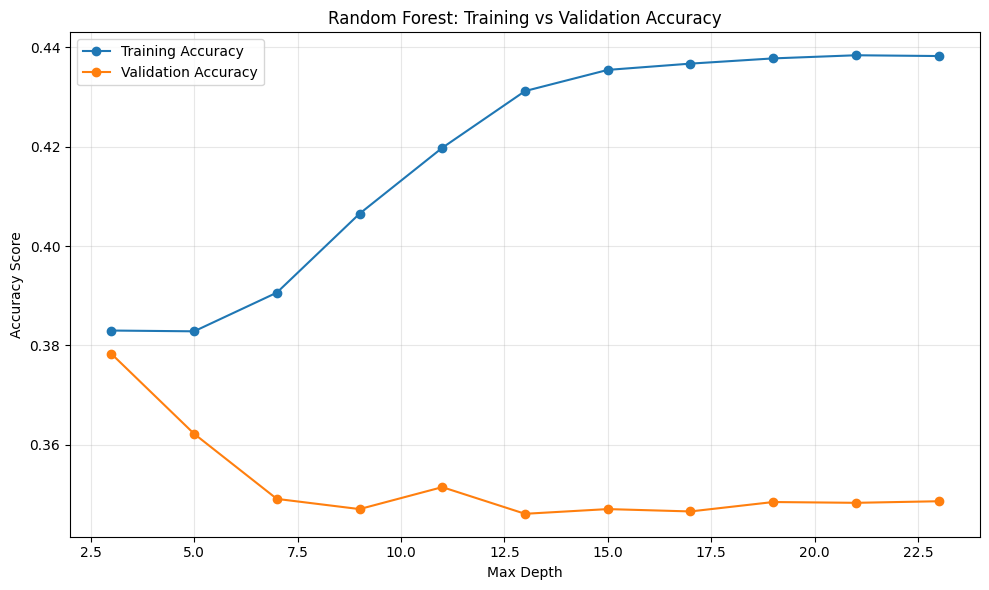

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",100
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [62]:
model_preparation(X, y)

In [ ]:
model = best_model(X, y, max_depth=3, n_estimators=500)

Train score: 0.3815
Val score: 0.3748
Test score: 0.3272

Test Confusion Matrix:
[[1398  355  158  424   61]
 [ 656  230  104  374   73]
 [ 685  189  104  325   69]
 [ 139   70   44  266   54]
 [ 135   64   38  243   74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.58      0.52      2396
           1       0.25      0.16      0.20      1437
           2       0.23      0.08      0.11      1372
           3       0.16      0.46      0.24       573
           4       0.22      0.13      0.17       554

    accuracy                           0.33      6332
   macro avg       0.27      0.28      0.25      6332
weighted avg       0.32      0.33      0.30      6332



#### Feature Importance

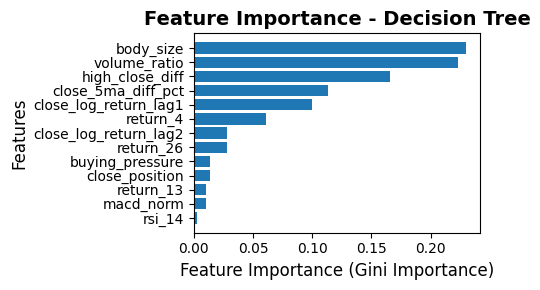


Top 10 Most Important Features:
              feature  importance
            body_size    0.230291
         volume_ratio    0.223537
      high_close_diff    0.165621
   close_5ma_diff_pct    0.113579
close_log_return_lag1    0.099994
             return_4    0.060976
close_log_return_lag2    0.027938
            return_26    0.027639
      buying_pressure    0.013905
       close_position    0.013716

Bottom 10 Least Important Features:
              feature  importance
   close_5ma_diff_pct    0.113579
close_log_return_lag1    0.099994
             return_4    0.060976
close_log_return_lag2    0.027938
            return_26    0.027639
      buying_pressure    0.013905
       close_position    0.013716
            return_13    0.010273
            macd_norm    0.010178
               rsi_14    0.002353


In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the decision tree
feature_importance = pd.DataFrame({
    'feature': X.columns,  # Your feature names
    'importance': model.feature_importances_  # Feature importances for tree models
}).sort_values('importance', ascending=False)

# Create the chart
plt.figure(figsize=(5, 3))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Gini Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Print bottom 10 features (least important)
print("\nBottom 10 Least Important Features:")
print(feature_importance.tail(10).to_string(index=False))

# Show features with zero importance (can be removed)
zero_importance = feature_importance[feature_importance['importance'] == 0]
if len(zero_importance) > 0:
    print(f"\n{len(zero_importance)} features have ZERO importance (consider removing):")
    print(zero_importance['feature'].tolist())

#### Sanity Check before walk forward

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 95% train, 5% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

# Train model
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Overfit Gap: {(train_acc - test_acc):.4f}")

y_pred = model.predict(X_test)
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

Train: 30073 samples
Test: 1583 samples

Train Accuracy: 0.3698
Test Accuracy: 0.3784
Overfit Gap: -0.0086

Confusion Matrix:
[[479  59  21 137   8]
 [209  40  23  88  10]
 [197  30  19  80   9]
 [ 26   8   5  57   4]
 [ 22   5   3  40   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.68      0.59       704
           1       0.28      0.11      0.16       370
           2       0.27      0.06      0.09       335
           3       0.14      0.57      0.23       100
           4       0.11      0.05      0.07        74

    accuracy                           0.38      1583
   macro avg       0.26      0.29      0.23      1583
weighted avg       0.37      0.38      0.33      1583



In [66]:
# Quick test of different depths
for depth in [3, 5, 6, 8]:
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=depth,
        min_samples_split=100,
        min_samples_leaf=50,
        max_features='sqrt',
        max_samples=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    print(f"Depth={depth}: Train={train_acc:.4f}, Test={test_acc:.4f}, Gap={train_acc-test_acc:.4f}")

Depth=3: Train=0.3698, Test=0.3784, Gap=-0.0086
Depth=5: Train=0.3727, Test=0.3708, Gap=0.0019
Depth=6: Train=0.3756, Test=0.3538, Gap=0.0218
Depth=8: Train=0.3859, Test=0.3418, Gap=0.0442


#### Backtesting Angel one

In [68]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54     12662
           1       0.28      0.26      0.27      6331
           2       0.28      0.17      0.22      6331
           3       0.26      0.51      0.34      3166
           4       0.31      0.42      0.35      3166

    accuracy                           0.38     31656
   macro avg       0.34      0.37      0.34     31656
weighted avg       0.40      0.38      0.38     31656

